![alt text](gisma_logo.png "logo")

<h1><center>M507: ML Pipeline</center></h1>
<h5><center>Submitted by: Faiz Qureshi, GH1018786
<h5><center>Module Leader: Prof. Dr. Mohammad Mahdavi

![alt text](cover.png "cover")

<h1><center>Automated Fashion Tagging</center></h1>

# Table of contents

- <a href='#1'>Context </a> 
- <a href='#2'>Problem Statement </a> 
- <a href='#3'>Data Exploration </a> 
- <a href='#4'>Data Preparation </a> 
- <a href='#5'>Modeling </a>
- <a href='#6'>Evaluation </a>
- <a href='#7'>Conclusion </a>
- <a href='#8'>References </a>


# <a id='1'>Context<a>


Ask any warehouse manager what their workers spend most time on, inventory tagging and management will definitely be one of their top choices. Moreover what's frustrating is that it is a mundane task that could do well to be automated.

I work for Zalando as a senior Data Scientist. At our organization, we take pride in being early adopters and developers of great technology. We deal with large amounts of inventory and each fashion article has specific storage and care needs. This is one of our biggest pain points, since we have to do this repetetive step manually. As such, I have been tasked with building a pipeline which can automate inventory tagging for our warehouses.


# <a id='2'>Problem Statement <a>


Zalando is working with a leading robotics company to install an automated physical pipeline, which can capture images of clothing articles. These images will be passed to a ML pipeline deployed on an edge device, which will classify it into one of the predefined categories.

Based on this, the article will be moved to appropriate storage.

In simple terms, this is an Image Classification problem. We will approach this with a TensorFlow based CNN model.


# <a id='3'>Approach<a>


### Limitations
- We have limited turnaround time for the first cut, since we need to coordinate with the robotics team which will deploy this model on edge devices
- We also have limited compute resources
- The aim of this pipeline is not to be SOTA, but to prove the viability of an ML based solution

### Data

Thanks to Zalando's online catalogue, we have access to a large dataset with over 16,000 images labeled in 6 categories. This data is available at https://www.kaggle.com/datasets/dqmonn/zalando-store-crawl

However, due to limitations stated above, we will only use a fraction of the data. I have prepared a 2% sample from this master data. This sample data has about 300 images from 2 classes (shirts and hoodies). For convenience, I have hosted this dataset on a public Github repo.

Let us get started!

*Please note: this notebook was run on Google Colab due to restrictions with our Jupyter Hub. As such, some directory structure may need to be modified if being run on JupyterHub.*


# <a id='4'>Data Exploration<a>


All our imports for this notebook are in one place and we have categorized the imports below.

In [ ]:
# Only for use with colab
# Mounting drive gives persistent storage across runtimes
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Utils
import os
import random
import requests
from zipfile import ZipFile

# Plotting
import matplotlib.pyplot as plt
import numpy as np

# Image lib
import PIL

# TF imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Let us get the data from Github and begin exploring it.

In [4]:
# Original data source in references
# Random sample of 2 categories extracted from it
# Hosted on Github for easy access
ds_name = 'zalando_sample'
data_url = r'https://raw.githubusercontent.com/FzQureshi/Datasets/main/'
data_url += ds_name + '.zip'
resp = requests.get(data_url, allow_redirects=True)

# Write to filesystem
with open (ds_name + '.zip', 'wb') as f:
    f.write(resp.content)
os.listdir()

['.config', 'zalando_sample.zip', 'drive', 'sample_data']

Data has been downloaded. However, it is a zip file. Let us unzip it.

In [5]:
# Unzip
with ZipFile(ds_name + '.zip', 'r') as zip_f:
        # Extract contents in current dir
        zip_f.extractall()
os.listdir()

['.config',
 'zalando_sample',
 '__MACOSX',
 'zalando_sample.zip',
 'drive',
 'sample_data']

In [6]:
os.listdir(ds_name)

['train', 'test', '.DS_Store']

As seen, we have 2 directories in our sampled data. Let's count the number of files in each of them.

In [7]:
def count_files(dir_path, file_ext):
    for obj in os.listdir(dir_path):
        if os.path.isdir(os.path.join(dir_path, obj)):
            files = os.listdir(os.path.join(dir_path, obj))
            rel_files = [f for f in files if f.endswith(file_ext)]
            print(f'{obj} directory has {len(rel_files)} files')

In [8]:
train_dir = ds_name + '/train/'
test_dir = ds_name + '/test/'

In [9]:
print('Training: ')
count_files(train_dir, '.jpg')

Training: 
shirt directory has 135 files
hoodies directory has 135 files


In [10]:
print('Testing: ')
count_files(test_dir, '.jpg')

Testing: 
shirt directory has 15 files
hoodies directory has 15 files


So, we have 135 images for each class in training.
Additionally, we have 15 images for an unseen test.

Our classes are perfectly balancd, so we do not need to perform any steps for oversampling.



Let us check some images from training set randomly.

In [11]:
# See a few random samples from each directory
def rand_file(cat_dir):
#cat_dir = os.path.join(train_dir, cat)
    if os.path.isdir(cat_dir):
        files = os.listdir(cat_dir)
        r = random.randint(0, len(files) + 1)
        print(f'A random sample image from {cat_dir}')
        img_path = os.path.join(cat_dir, files[r])
        return(img_path)
        #PIL.Image.open(img_path)

A random sample image from zalando_sample/train/hoodies


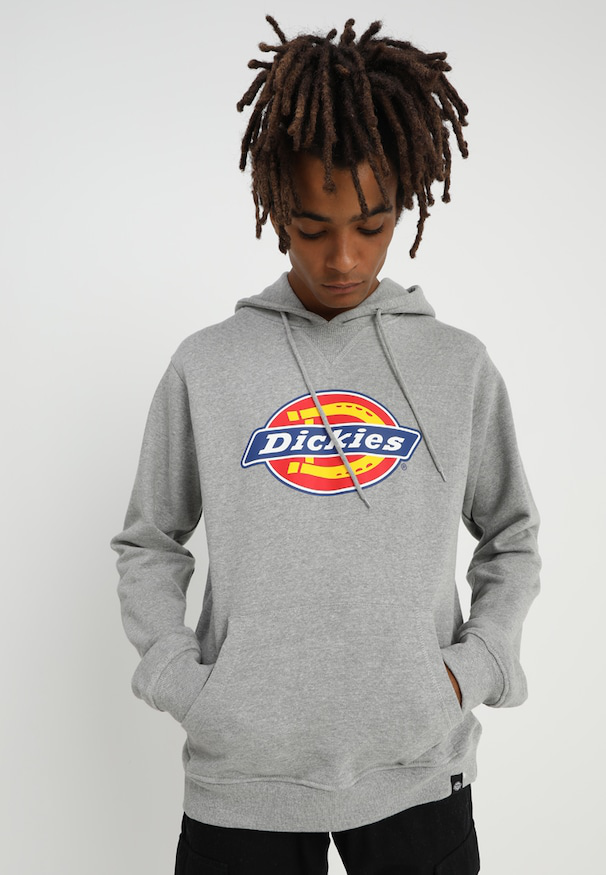

In [12]:
cat = 'hoodies'
PIL.Image.open(rand_file(os.path.join(train_dir, cat)))

A random sample image from zalando_sample/train/shirt


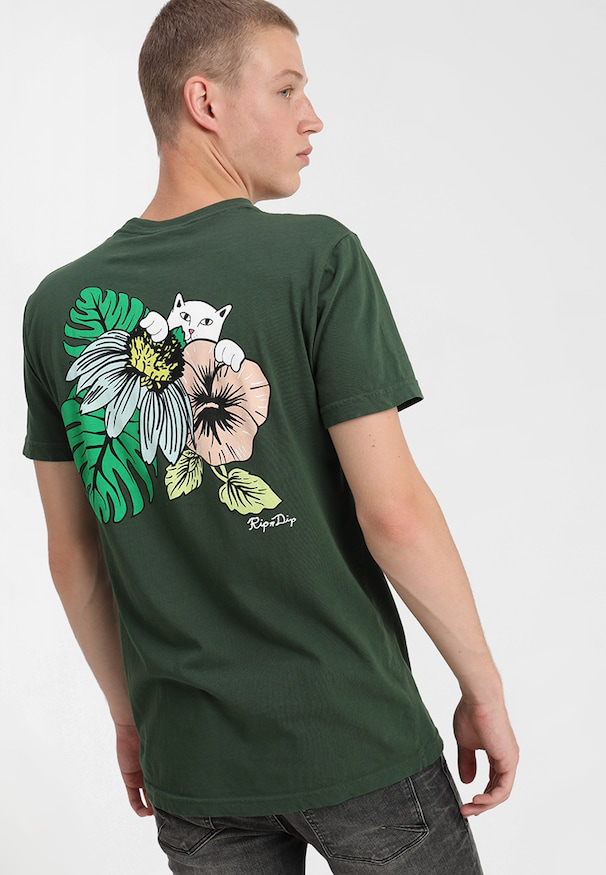

In [13]:
cat = 'shirt'
PIL.Image.open(rand_file(os.path.join(train_dir, cat)))

Let us check the size of the images.

In [14]:
sizes = set()
for cat in ['shirt', 'hoodies']:
    for img_file in os.listdir(os.path.join(train_dir, cat)):
        if img_file.endswith('.jpg'):
            img = PIL.Image.open(os.path.join(train_dir, cat, img_file,))
            sizes.add(img.size)
sizes

{(606, 875)}

As seen from above, all our images have ```606``` pixels in width and ```875``` pixels in height. They are all uniform. We just might need to rescale them in the following section.


# <a id='4'>Data Preparation<a>


Thanks to being provided straight from the source, our data is quite clean.

For preparing the images for our pipeline, we will rely on TensorFlow's inbuilt helper functions. Particularly, we will use ```image_dataset_from_directory```. This makes building a dataset from images simple, efficient and fast.

First, let us define some parameters to be used by this function:

- ```batch_size``` determines the number of samples that are yielded by the dataset in one go. Higher batch_size typically results in faster training, at the cost of higher memory usage. Since we have limited memory, we will use a batch size of 16.

-  The native image resolution ```875 x 606``` is too high. We will scale these down when building our dataset.

- We will resize to ```220 x 150``` pixels. This way, we will be reducing the size by a factor of 16 (4 x 4), while still maintaing the image's aspect ratio.

In [15]:
# Define some params
batch_size = 16
img_h, img_w = 220, 150


- While building, we can even specify a split for validation. We will use 20 % for validation. Note that this is separate from the 15 images per category that we had already separated for testing.

- We will also shuffle the data while forming the dataset.
- The seed value is used for seeding the randomization of split.
- By default each pixel is broken down to 3 channels - RGB. That suits us.

In [16]:
training_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_h, img_w),
  batch_size=batch_size,
  validation_split=0.2,
  subset="training",
  seed=42,
  shuffle=True)

Found 270 files belonging to 2 classes.
Using 216 files for training.


In [17]:
validation_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_h, img_w),
  batch_size=batch_size,
  validation_split=0.2,
  subset="validation",
  seed=42,
  shuffle=True)

Found 270 files belonging to 2 classes.
Using 54 files for validation.


Training set has 216 images, validation set has 54 images.

In [18]:
class_names = training_data.class_names
print(class_names)

['hoodies', 'shirt']


Class names were automatically inferred from the directory names.


Let us see some samples from our training dataset. 

We will use the datasets inbuilt ```take()``` function to yield a batch (16 images) of data.

We can plot one batch of images from our dataset in a grid using matplotlib's ```imshow``` function.

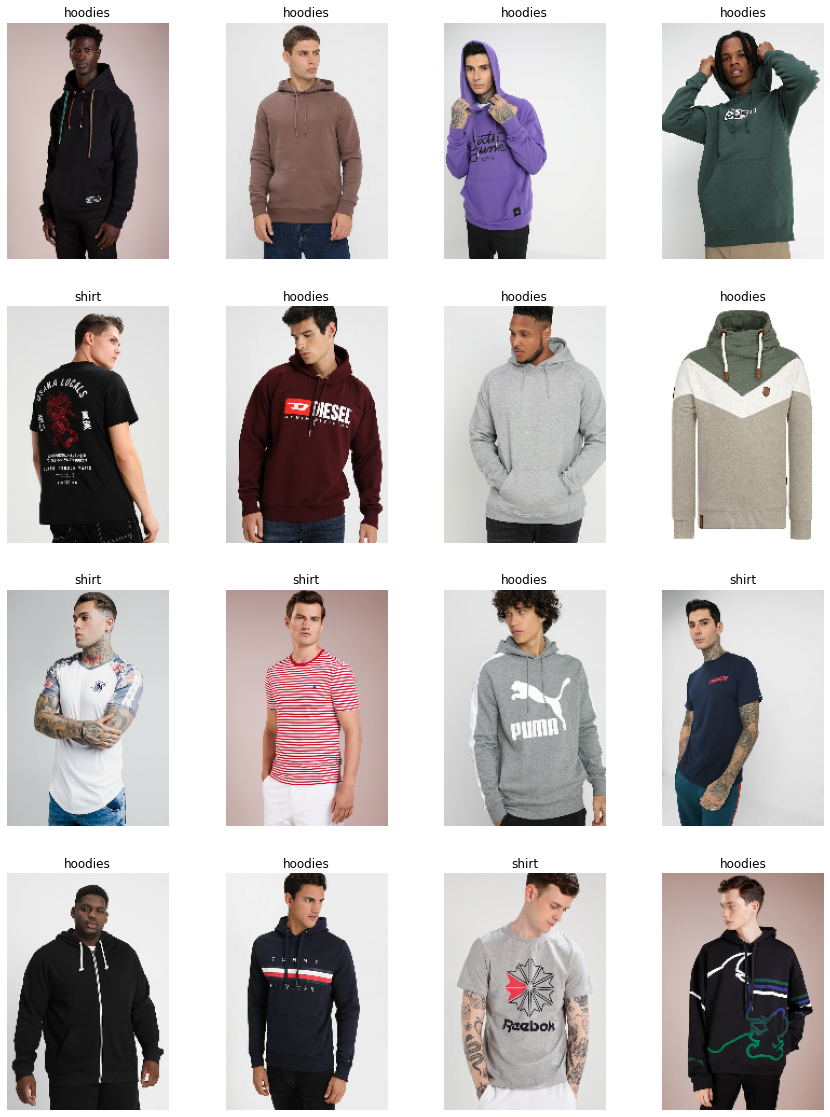

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))
for images, labels in training_data.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The above represents one batch of images from our dataset.

Let us look at how the shape of the tensors representing our data.
Remember we have both an image and a label.

In [20]:
for img_btch, lbl in training_data:
    print(img_btch.shape)
    print(lbl.shape)
    break

(16, 220, 150, 3)
(16,)


A batch of images has a tensor shape of ```(16, 220, 150, 3)```. Here:
- ```16``` represents the batch size
- ```220``` is the height of each image
- ```150``` is the width of each image
- ```3``` represents the RGB channels used to represent the intensity of each colour in a pixel

The label is represented by a tensor of ```(16, )``` which just contains the label for each of the 16 images in the batch.

Training Deep Neural Networks can be time consuming, memory intensive or both. Thus, we need to optimize each possible step. Some ways of doing this is by prefetching data into memory and caching it ahead of intended usage. IO operations can notroiously slow down a pipelines training stage and a good cache can remedy that. Manually implementing something like this can be quite challenging.


Fortunately, Tensorflow provides convenient methods to do this. By feeding the created model, available compute resources and real-time model training metrics, these methods optimize the created pipeline. Additionally, we can use the ```AUTOTUNE``` functionality, which auto-determines the buffer size. 



Along with ```cache``` and ```prefetch```, we will use the ```shuffle``` method on training data, so that each time the the results yielded from the cache are in a random order.

In [21]:
# Get the optimal buffer size automatically
buff_size = tf.data.AUTOTUNE

# Prefetch and cache the data
# Additionally, shuffle the training data
train_data = training_data.cache().shuffle(100).prefetch(buffer_size=buff_size)
validation_data = validation_data.cache().prefetch(buffer_size=buff_size)


# <a id='5'>Modeling<a>


We are now ready to build the different layers of our Neural Network!

- The RGB intensity can range from 0 to 255. This can be detrimental when building a NN. It is always a good idea to normalize tthis by rescaling. We will use a ```Rescaling``` layer to normalize our input. Input shape for this will naturally be the same shape as the tensor representing a single image.


- A convolutional layer will create filters and apply them to the inputs. By repeating this application multiple times across an image, the pipeline can learn to identify the positions of a target in an image.


- We will stack multiple ```Conv2D```  and ```MaxPooling``` layers. The intuition for this is that the first Conv2D layer will learn low-level features, like edges and basic shapes. The next Conv2D layer will then use this and learn mid-level features, like collars and sleeves. Finally the third Conv2D layer should be able to identify high-level features like the type of a clothing article. Between each Conv2D layer, we will have a MaxPooling layer, which helps by introducing some translational variance and also reducing dimensionality. This can help our model generalize better.


- For our Conv2D layers, we will use 16, 32 and 64 filters and our kernel_size will be 3x3. These are chosen because they have been emprircally found to be good default values. Moreover, a kernel_size of 3x3 provides a good balance of performance and speed. Note that a kernel size should ideally be odd, since it provides more symmetry around the center.


- Before providing output, we will use the ```Flatten``` layer to flatten our output to a single dimension. This is so that it can be fed to the final output layers.


- Next, we will use a fully connected ```Dense``` to help classify the extracted high-level features. We will use 128 units in this layer - this number was chosen experimentally.


- Finally, we will use another ```Dense``` layer with number of units equal to number of classes (which is 2 in out case) to provide the output.


- For our Conv2D and Dense layers, we will use an activation function to increase the non-linearity in the network. We will use ReLu since it is inexpensive to calculate and acts as agood starting point.


In [ ]:
num_classes = len(class_names)

act_fn = 'relu'

# Basic building block
model = Sequential()

# Rescale the input between (0, 1)
model.add(layers.Rescaling(1./255, input_shape=(img_h, img_w, 3)))

# First layer for low-level features
model.add(layers.Conv2D(16, 3, padding='same', activation=act_fn))
model.add(layers.MaxPooling2D())

# Second layer for mid-level features
model.add(layers.Conv2D(32, 3, padding='same', activation=act_fn))
model.add(layers.MaxPooling2D())

# Third layer for high-level features
model.add(layers.Conv2D(64, 3, padding='same', activation=act_fn))
model.add(layers.MaxPooling2D())

# Flatten to feed to out
model.add(layers.Flatten())

# Output layers
model.add(layers.Dense(128, activation=act_fn))
model.add(layers.Dense(num_classes))

While compiling, we will use 
- ```Adam``` as an optimizer as it is the go-to optimizer for most use-cases.
- ```sparse_categorical_crossentropy``` loss function, since we have 4 categorical classes to predict
-```accuracy```, ```precision``` and ```recall``` as metrics

- In our loss function, we will set ```from_logits``` to ```True```. This is because our output is a logit - it is not passed through an activation like softmax. Instead we will use softmax while making the prediction.

In [23]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_func,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 220, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 75, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 75, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 37, 64)        1

- The model summary above shows the output shapes of each layer.


- Input shape of first layer and output shape of last layer need to be explicitly specified.


- For the middle layers, TensorFlow automatically assigns the output shape of the previous layer as the input shape for the current layer.


Let us train our model for 20 epochs. We have chosen 20 so that the model has enough time to learn. At the same time, we do not have a small amount of data and only 2 classes. So 20 should be a reasonable choice.

In [24]:
epochs = 20

model_history = model.fit(training_data, validation_data=validation_data,
                          epochs=epochs)

Epoch 1/20
14/14 [==============================] - 10s 585ms/step - loss: 1.1541 - accuracy: 0.5046 - val_loss: 0.6961 - val_accuracy: 0.5185
Epoch 2/20
14/14 [==============================] - 8s 550ms/step - loss: 0.6780 - accuracy: 0.5417 - val_loss: 0.6652 - val_accuracy: 0.6852
Epoch 3/20
14/14 [==============================] - 8s 554ms/step - loss: 0.6052 - accuracy: 0.7083 - val_loss: 0.8889 - val_accuracy: 0.5741
Epoch 4/20
14/14 [==============================] - 8s 552ms/step - loss: 0.5273 - accuracy: 0.7083 - val_loss: 0.6268 - val_accuracy: 0.6111
Epoch 5/20
14/14 [==============================] - 8s 558ms/step - loss: 0.3985 - accuracy: 0.7963 - val_loss: 0.4991 - val_accuracy: 0.7593
Epoch 6/20
14/14 [==============================] - 8s 551ms/step - loss: 0.3292 - accuracy: 0.8843 - val_loss: 0.7633 - val_accuracy: 0.5926
Epoch 7/20
14/14 [==============================] - 8s 556ms/step - loss: 0.2540 - accuracy: 0.8889 - val_loss: 0.4658 - val_accuracy: 0.7593
Epoch

Now that our model is trained, let us have a quick look at the training history. We will create a function to plot this, since we might need to retrain and repeat this process.

In [3]:
def plot_model_history(hist, epochs):

    x_axis = range(1, epochs + 1)
    
    # Accuracy and loss for training set
    train_acc = hist.history['accuracy']
    train_loss = hist.history['loss']
    
    # Accuracy and loss for validation set
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Plot accuracies on one graph
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, train_acc, label='Train')
    plt.plot(x_axis, val_acc, label='Validation')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    # Plot losses on other graph
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, train_loss, label='Train')
    plt.plot(x_axis, val_loss, label='Validation')
    plt.legend(loc='upper left')
    plt.title('Loss')
    plt.show()

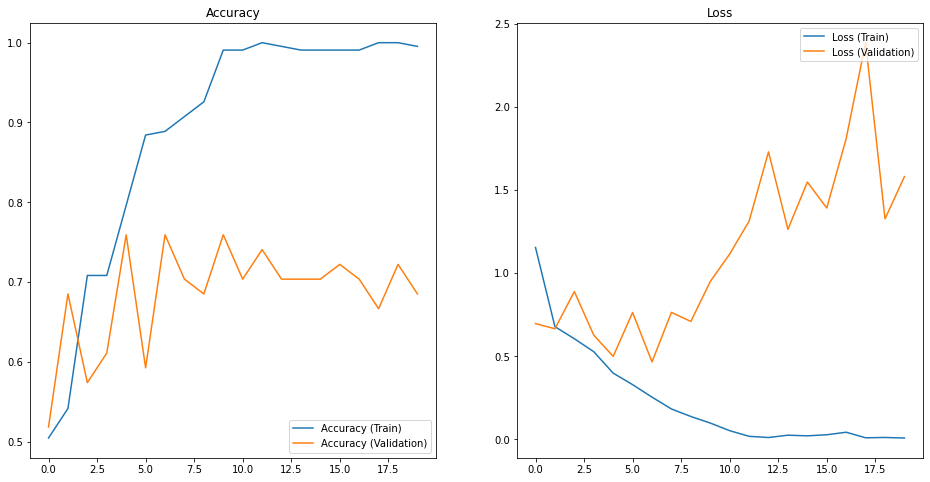

In [26]:
plot_model_history(model_history, epochs)

From the plots above, we see that the pipeline reached nearly 100% accuracy on the training data. Meanwhile the accuracy on validation data is closer to 70%. There is more than 25% gap in these accuracies!

Same pattern is shown by the loss. In fact in the last few epochs, the loss on validation set actually spikes up. All this indicates that our pipeline is probably overfitting the data.


### Rectifying overfitting

We will perform 2 steps to try and fix this:

- Add a ```Dropout``` layer. This layer randomly turns off a fraction of the neurons, so as to provide variance. This helps us generalize better.

- Add a ```data_augmentation``` step which will have 4 layers to create variations of the existing images using:
    - RandomFlip
    - RandomRotation
    - RandomZoom
    - RandomContrast



In [27]:
# Create an augmentation layer which randomly modifies the image with 10% prob
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal", input_shape=(img_h, img_w, 3)),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1),
     layers.RandomContrast(0.1),
     ]
     )

Let us see how some of our augmented images may look:

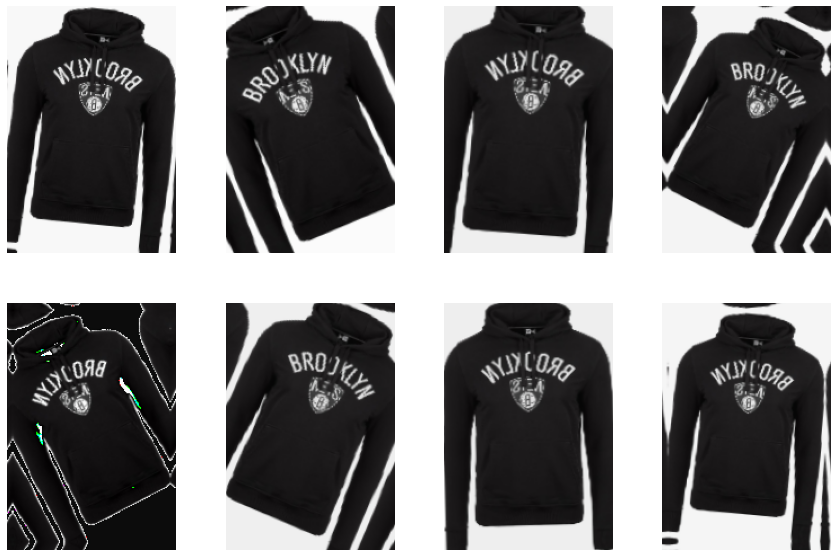

In [28]:
plt.figure(figsize=(15, 10))
for img_batch, _ in training_data.take(1):
  for i in range(8):
    augmented_img_batch = data_augmentation(img_batch)
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_img_batch[0].numpy().astype("uint8"))
    plt.axis("off")

As seen above, the images are randlomly rotated, flipped, zoomed in or contrasted. These variations should help our model generalize better.

Let us rebuild our model with these 2 layers added. We will dropout 15% of neurons.

In [29]:
act_fn = 'relu'

# Basic building block
model_2 = Sequential()

# Add the newly created data-aug layer
model_2.add(data_augmentation)

# Rescale the input between (0, 1)
model_2.add(layers.Rescaling(1./255, input_shape=(img_h, img_w, 3)))

# First layer for low-level features
model_2.add(layers.Conv2D(16, 3, padding='same', activation=act_fn))
model_2.add(layers.MaxPooling2D())

# Second layer for mid-level features
model_2.add(layers.Conv2D(32, 3, padding='same', activation=act_fn))
model_2.add(layers.MaxPooling2D())

# Third layer for high-level features
model_2.add(layers.Conv2D(64, 3, padding='same', activation=act_fn))
model_2.add(layers.MaxPooling2D())

# Add Dropout to improve generalization
model_2.add(layers.Dropout(0.15))

# Flatten to feed to out
model_2.add(layers.Flatten())

# Output layers
model_2.add(layers.Dense(128, activation=act_fn))
model_2.add(layers.Dense(num_classes))

In [30]:
model_2.compile(optimizer='adam',
              loss=loss_func,
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 220, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 220, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 75, 16)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 110, 75, 32)       4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 37, 32)       0         
 2D)                                                  

In [32]:
model_2_history = model_2.fit(training_data, validation_data=validation_data,
                          epochs=epochs)

Epoch 1/20
14/14 [==============================] - 11s 646ms/step - loss: 1.3011 - accuracy: 0.4769 - val_loss: 0.7021 - val_accuracy: 0.4815
Epoch 2/20
14/14 [==============================] - 10s 634ms/step - loss: 0.6886 - accuracy: 0.5602 - val_loss: 0.6780 - val_accuracy: 0.5370
Epoch 3/20
14/14 [==============================] - 9s 630ms/step - loss: 0.6643 - accuracy: 0.6528 - val_loss: 0.7063 - val_accuracy: 0.5370
Epoch 4/20
14/14 [==============================] - 10s 633ms/step - loss: 0.6539 - accuracy: 0.6250 - val_loss: 0.6649 - val_accuracy: 0.5926
Epoch 5/20
14/14 [==============================] - 10s 630ms/step - loss: 0.6296 - accuracy: 0.6389 - val_loss: 0.6155 - val_accuracy: 0.6296
Epoch 6/20
14/14 [==============================] - 10s 642ms/step - loss: 0.5432 - accuracy: 0.7546 - val_loss: 0.5986 - val_accuracy: 0.6667
Epoch 7/20
14/14 [==============================] - 10s 636ms/step - loss: 0.5269 - accuracy: 0.7593 - val_loss: 0.5750 - val_accuracy: 0.7222


Let us plot the history to visualize the accuracy and loss.

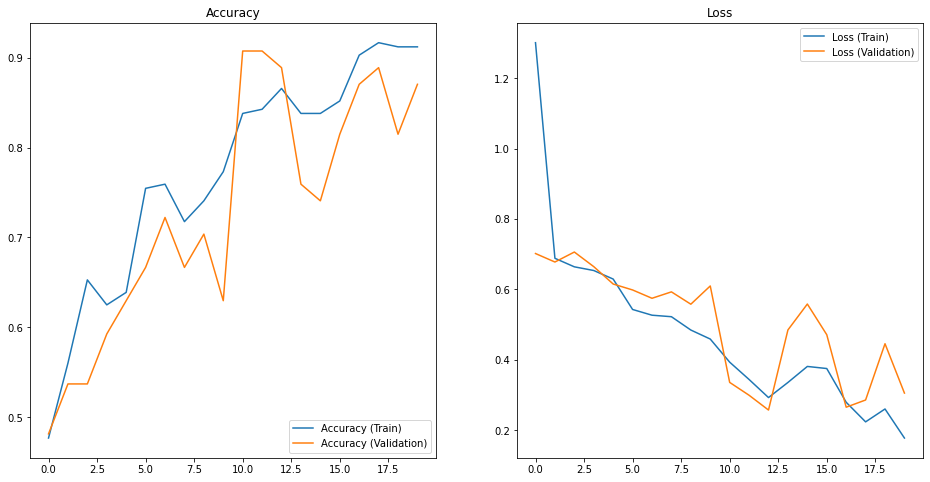

In [33]:
plot_model_history(model_2_history, epochs)

That looks much better now!
Out training set accuracy was 91% and validation set accuracy was 87%. That's an acceptable difference of 4%. Let us save this model, so that it persists.

In [36]:
# Save the model to be used later
from tensorflow.keras.models import save_model

# CHANGE THIS IF YOU ARE NOT USING GOOGLE COLAB
base_path = '/content/drive/MyDrive/M507_models/'

model_name = 'cnn_classifier_' + str(epochs)
model_path = base_path + model_name
save_model(model_2, model_path, overwrite=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/M507_models/cnn_classifier_20/assets



# <a id='6'>Evaluation<a>


Let us create a function which takes an image path and makes a prediction for that image based on our model.


In [37]:
def predict_cat(img_path, model, img_dim):
    # Load the image
    test_img = tf.keras.utils.load_img(img_path, target_size=img_dim)

    # Process it same as we did for training data
    test_img_arr = tf.keras.utils.img_to_array(test_img)
    test_img_arr = tf.expand_dims(test_img_arr, 0) 

    # Make the prediction
    predictions = model.predict(test_img_arr)

    # Convert score to percent
    score = tf.nn.softmax(predictions[0])

    conf = 100 * round(np.max(score), 2)
    pred_class = class_names[np.argmax(score)]

    return pred_class, conf

Let us see if our function works as expected.

Predicted as "hoodies" with 100.0% confidence


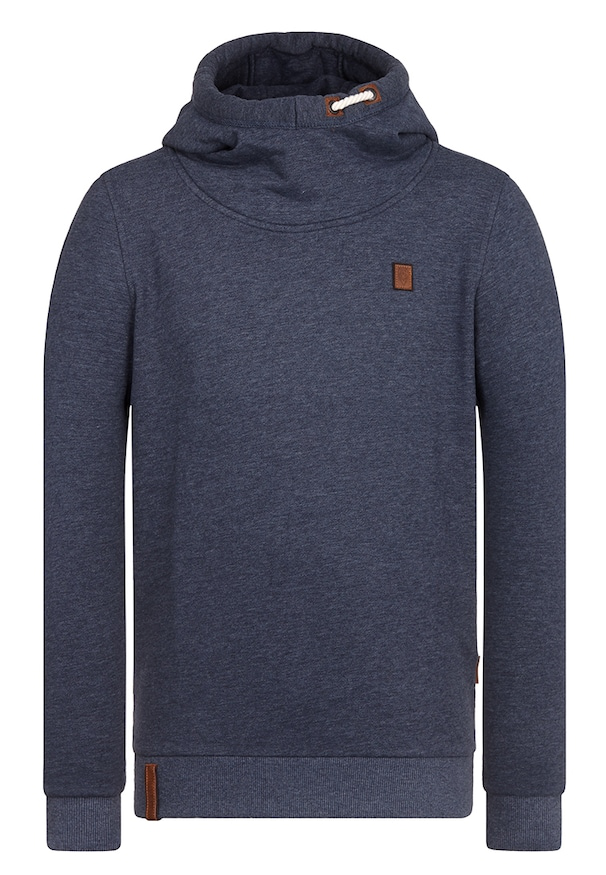

In [39]:
img_path = 'zalando_sample/test/hoodies/2NA22S091-K18@1.1.jpg'
cls, conf = predict_cat(img_path, model_2, (img_h, img_w))
print(f'Predicted as "{cls}" with {conf}% confidence')
PIL.Image.open(img_path)

Great! Now let us run through the unseen test set. The code below will record accuracies in a dict.

In [41]:
accuracies = {}
for cat in class_names:
    acc = 0
    base_dir = test_dir + cat + '/'
    files = [f for f in os.listdir(base_dir) if f.endswith('.jpg')]
    for file in files:
        img_path = base_dir + file
        cls, conf = predict_cat(img_path, model_2, (img_h, img_w))
        if cls == cat:
            acc += 1
    acc /= len(files)
    accuracies[cat] = round(acc, 2)

accuracies

{'hoodies': 0.73, 'shirt': 0.8}


- We got 73% accuracy for hoodies and 80% for shirts.

- The next step would usually be to check the confidence scores of the images which were misclassified and also visually observe those images to see any peculiarities.

- We can also improve our pipeline by feeding it more data. So far we only used 2% of the available data due to constraints.

To keep this pipeline concise, we shall stop here.


# <a id='7'>Conclusion<a>


- With the constraints that were set, our pipeline performs reasonably well.


- The initially trained model showed clear signs of overfitting the data. This was remedied by creating more diverse data and by dropping out some neurons.


- On the completely unseen test set, we got an accuracy of about 77%. Accuracy on hoodies was slightly lower. We can include additional data for hoodies to improve performance here.


- For many of the parameters set in CNNs, there is no consensus on how to determine the best values. The only real way to go about it is to use intuition and experimentation. That means that further experimentation could potentially yield better results.


- Moreover, this is a binary classifer built on less than 3% of the actually available data. With enough compute power and time, we can create a much better pipeline. Further, this pipeline can be extended to perform multi-label classifications. Using this, we can for example, we can classify an article as a "Red women's hoodie".


- Building on this, the long term plan is to develop a model which can even tag attributes like material used, style and other article features. Using this, we can also augment our online catalogues, by automatically recommending articles based on these tags.


- Such a pipeline is quite promising and will greatly help in solving the inventory management overheads and prove to be a pivotal step as Zalando switches to increased automation in its warehouses, as well as online.



# <a id='8'>References<a>


- Dataset sourced from https://www.kaggle.com/datasets/dqmonn/zalando-store-crawl

- Dataset hosted at https://raw.githubusercontent.com/FzQureshi/Datasets/main/zalando_sample.zip

- TF Docs: https://www.tensorflow.org/api_docs/python/tf

- Andrew NG's CNN example: https://www.youtube.com/watch?v=bXJx7y51cl0&t=375s&ab_channel=DeepLearningAI

- Choosing a filter and kernel size for Convolution Layers: https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15

- Activation functions: https://towardsdatascience.com/everything-you-need-to-know-about-activation-functions-in-deep-learning-models-84ba9f82c253


‌